<a href="https://colab.research.google.com/github/arkeodev/demistify_deep_learning_applications/blob/main/YOLO_Object_Detection_From_Theory_to_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demistifying YOLO Object Detection for myself: From Theory to Implementation

Object detection is a crucial task in computer vision that involves identifying and localizing objects within an image. Among the numerous approaches to object detection, YOLO (You Only Look Once) has emerged as one of the most effective and efficient methods. In this blog post, we delve into the fundamentals of YOLO object detection, its implementation, and the implementation in PyTorch, with a focus on practical application using the COCO dataset.

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Understanding YOLO Object Detection

Understanding the core concepts behind YOLO (You Only Look Once) object detection is essential for mastering how it revolutionizes object detection tasks, particularly in terms of speed and accuracy. Let's delve deeper into the intricacies of YOLO, the concept of bounding boxes, and the crucial metric of Intersection Over Union (IoU).

When try to explain the details, I used the wonderful Medium entry of Jonathan Hui: [Real-time Object Detection with YOLO, YOLOv2 and now YOLOv3](https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)

### Deep Dive into YOLO Object Detection

YOLO fundamentally changes the object detection landscape by treating the task as a single regression problem from image pixels to bounding box coordinates and class probabilities. This approach contrasts sharply with traditional methods, which typically involve a two-step process: first proposing candidate regions (region proposals) and then classifying each region into various categories.

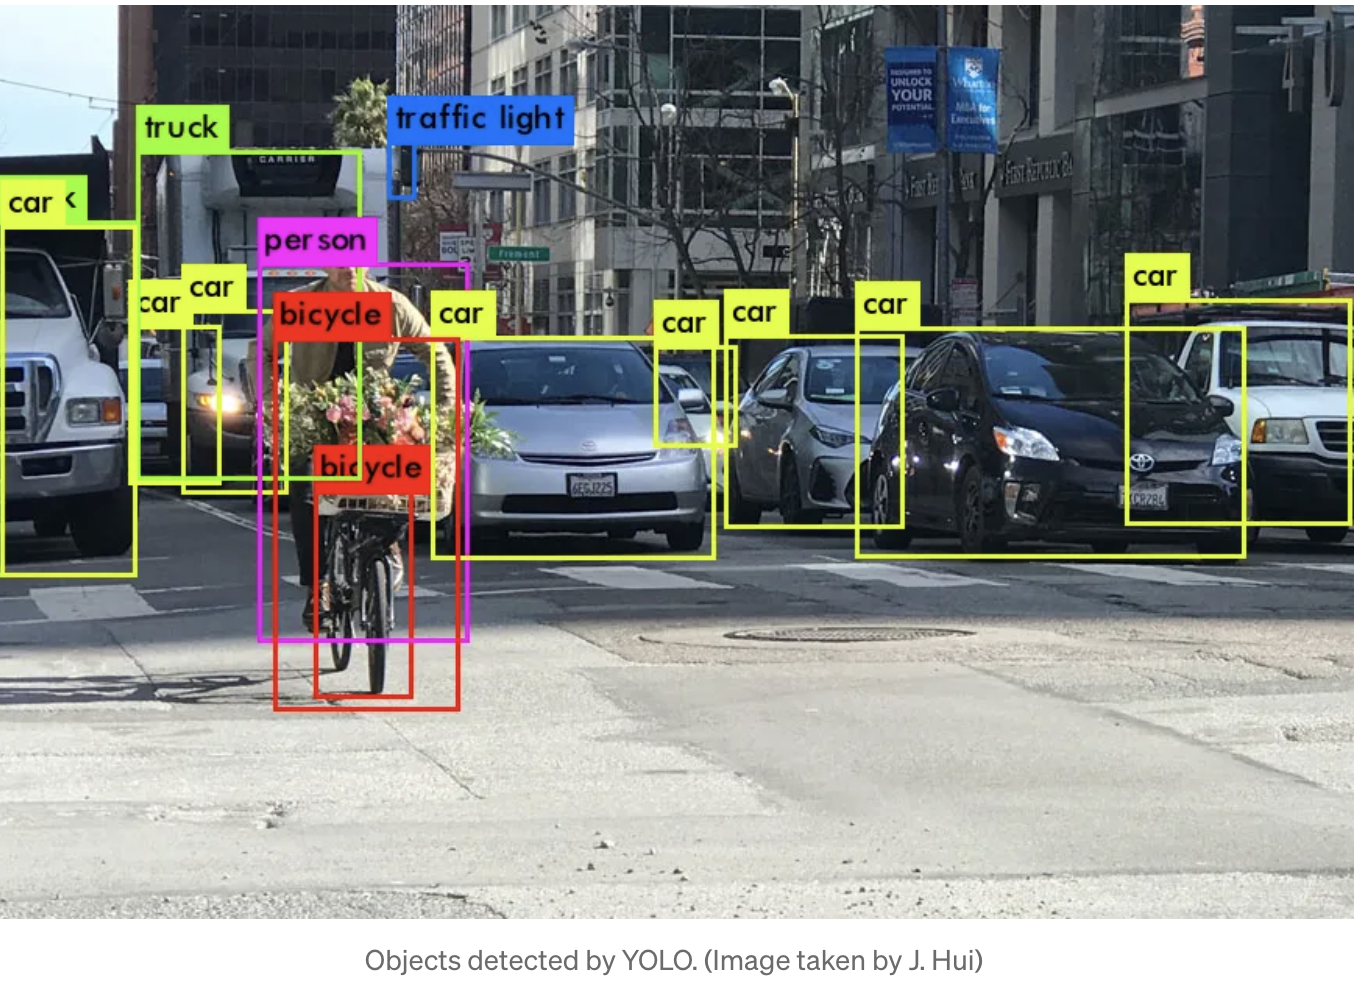

#### How YOLO Works:

1. **Single Convolutional Network:** YOLO uses a single convolutional network to predict multiple bounding boxes and class probabilities for those boxes simultaneously. This end-to-end training and prediction model dramatically increases the speed of detection.

2. **Spatial Division of Images:** The image is divided into an $(S×S$) grid, and for each grid cell, YOLO predicts $(B$) bounding boxes and confidence scores for those boxes. Confidence reflects the accuracy of the bounding box and the probability that the box contains a specific object.

3. **Class Probabilities:** Alongside bounding box predictions, YOLO also predicts class probabilities for each grid cell, irrespective of the number of boxes $(B$).

#### Advantages:

**Global Context:** Unlike region proposal-based methods, YOLO sees the entire image during training and test time, allowing it to implicitly encode contextual information about classes.

**Speed:** By simplifying the detection into a single network forward pass, YOLO achieves remarkable speed, making it suitable for real-time applications.

**Predictions** (object locations and classes) are made from one single network. Can be trained end-to-end to improve accuracy.

**YOLO is more generalized.** It outperforms other methods when generalizing from natural images to other domains like artwork.

**YOLO detects one object per grid cell.** It enforces spatial diversity in making predictions.

## Dataset and Preprocessing

### Understanding the COCO Format

For our implementation, we utilize the COCO dataset. The COCO (Common Objects in Context) dataset is a large-scale object detection, segmentation, and captioning dataset. The COCO format is a specific way that the dataset annotates images, making it a standard for various computer vision tasks. This format is particularly designed to facilitate the training and evaluation of algorithms on the dataset

The COCO dataset format organizes annotation information in a structured JSON file, which includes:

**Images:** A list of images with their file names, image IDs, URLs, height, and width.

**Annotations:** Contains details about each object instance in the images, including:
* Object bounding box coordinates (in the format `[x, y, width, height]`).
* The category ID of the object.
* An annotation ID unique to each object instance.
* Segmentation information for instance segmentation tasks.

**Categories:** Lists all object categories in the dataset, each with a unique category ID and name.

This structured format allows for easy parsing and utilization in training object detection models, supporting tasks like bounding box object detection and instance segmentation.

```
annotation{
  "id": int,
  "image_id": int,
  "category_id": int,
  "segmentation": RLE or [polygon],
  "area": float,
  "bbox": [x,y,width,height],
  "iscrowd": 0 or 1,
}

categories[{
  "id": int,
  "name": str,
  "supercategory": str,
}]
```

The COCO dataset can be accessed and downloaded from the [COCO Dataset Official Website](https://cocodataset.org/#home). Here, you can find links to download the images and annotations for different years and tasks, along with additional resources and tools for working with the dataset.

### Alternatives to the COCO Format

An alternative to the COCO format is the PASCAL VOC format, used by the PASCAL Visual Object Classes challenges. The VOC format stores annotations in XML files, with each file corresponding to an image in the dataset. While also widely used, the COCO format has become more popular for several reasons, particularly due to its support for a larger number of images and more detailed annotations, including instance segmentation masks.

### Why Prefer COCO Dataset and Format?

* **Diversity and Size:** The COCO dataset includes over 200,000 images with more than 500,000 object instances across 80 categories, offering a diverse and substantial volume of data for robust model training.

* **Multiple Tasks Support:** The COCO format supports various computer vision tasks, including object detection, segmentation, and image captioning, making it versatile for different applications.

* **Standardization:** The structured JSON format allows for consistency and standardization in data annotation, facilitating easier data parsing and model evaluation.

* **Community and Tools:** The widespread adoption of the COCO dataset has led to the development of numerous tools and libraries designed to work with COCO-formatted data, as well as a large community of researchers and developers contributing to continual improvements.

### Download the Data

First, let's create the directory structure where the dataset will be stored.

In [ ]:
!mkdir -p coco/images/train2017 coco/images/val2017 coco/annotations

Next, use the following commands to download the training and validation images and annotations for the COCO 2017 dataset. Note that these files are quite large, so the download may take some time depending on your internet connection.

In [ ]:
! wget http://images.cocodataset.org/zips/train2017.zip -P coco/images
! wget http://images.cocodataset.org/zips/val2017.zip -P coco/images
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P coco/annotations

--2024-03-04 18:49:48--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.211.209, 3.5.9.201, 52.217.196.57, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.211.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco/images/train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.3MB/s    in 5m 15s  

2024-03-04 18:55:03 (58.5 MB/s) - ‘coco/images/train2017.zip’ saved [19336861798/19336861798]

--2024-03-04 18:55:03--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.15.12, 52.216.48.137, 3.5.16.189, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.15.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco/images/val2017.zip’

val2017.zip       

After downloading, unzip the files to their respective directories.

In [ ]:
! unzip -q coco/images/train2017.zip -d coco/images
! unzip -q coco/images/val2017.zip -d coco/images
! unzip -q coco/annotations/annotations_trainval2017.zip -d coco/annotations

After executing these commands, your folder structure should look like this:

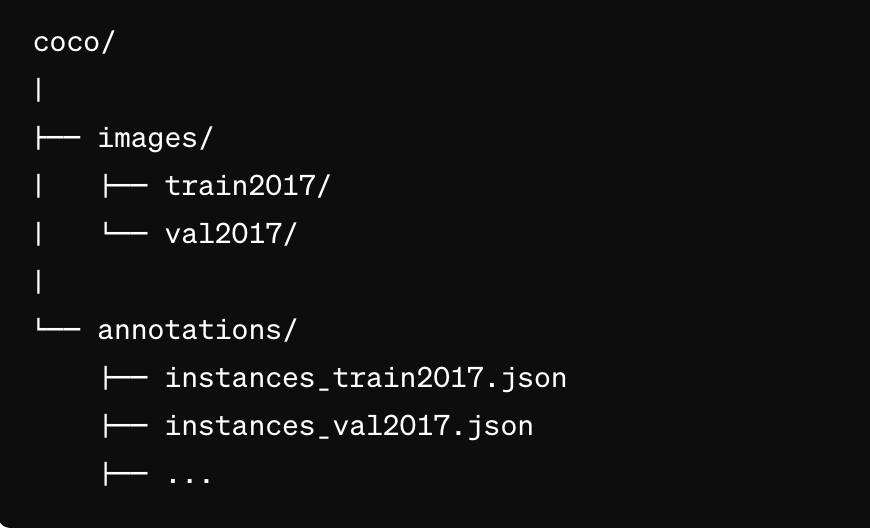


Optionally, after unzipping, you can remove the downloaded .zip files to save space.

In [ ]:
! rm coco/images/train2017.zip
! rm coco/images/val2017.zip
! rm coco/annotations/annotations_trainval2017.zip

### Dataset Preparation

Before diving into model building, it's crucial to prepare the dataset. For object detection, loading the images along with their corresponding bounding boxes and class labels.

In [ ]:
class CustomCocoDetection(CocoDetection):
    def __init__(self, root, annFile, transform=None, grid_size=7, num_classes=20, num_boxes=2, image_size=416):
        super(CustomCocoDetection, self).__init__(root, annFile)
        self.transform = transform
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        self.image_size = image_size
        # Define your class ID mapping here, in my cases I selected the below:
        self.coco_to_voc = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19}


    def __getitem__(self, index):
        img, targets = super(CustomCocoDetection, self).__getitem__(index)

        # Filter and remap annotations
        # Filter and remap annotations
        new_targets = []
        for obj in targets:
            coco_class_id = obj['category_id']
            if coco_class_id in self.coco_to_voc:
                # Remap class ID and update annotation
                obj['category_id'] = self.coco_to_voc[coco_class_id]
                new_targets.append(obj)

        if not new_targets:
            # Handle the case where an image has no annotations from the 20 classes
            return self.__getitem__((index + 1) % len(self))


        boxes = [obj['bbox'] for obj in new_targets]
        category_ids = [obj['category_id'] for obj in new_targets]

        # Convert the PIL image to a numpy array
        img = np.array(img)

        if self.transform:
            transformed = self.transform(image=img, bboxes=boxes, class_labels=category_ids)
            img = transformed['image']
            boxes = transformed['bboxes']
            category_ids = transformed['class_labels']

        # Encode targets
        encoded_targets = self.encode_targets(boxes, category_ids)

        return img, encoded_targets

    def encode_targets(self, boxes, category_ids):
        # Initialize the tensor for storing encoded targets
        encoded_targets = torch.zeros((self.grid_size, self.grid_size, 5 * self.num_boxes + self.num_classes), dtype=torch.float32)

        for box, class_id in zip(boxes, category_ids):
            # Check if class_id is in the defined range after remapping
            if class_id not in self.coco_to_voc.values():
                continue  # Skip if class_id is not in our subset of 20 classes

            # Adjusted assertion to check for class IDs in the range [0, num_classes-1]
            assert 0 <= class_id < self.num_classes, f"Class ID {class_id} out of bounds!"

            # Convert box from COCO to center format and normalize
            box_center_x = (box[0] + box[2] / 2) / self.image_size
            box_center_y = (box[1] + box[3] / 2) / self.image_size
            box_width = box[2] / self.image_size
            box_height = box[3] / self.image_size

            # Find the grid cell
            grid_x = int(box_center_x * self.grid_size)
            grid_y = int(box_center_y * self.grid_size)

            # Update encoded targets
            if encoded_targets[grid_y, grid_x, 4] == 0:  # Assuming one object per grid cell
                encoded_targets[grid_y, grid_x, :4] = torch.tensor([box_center_x, box_center_y, box_width, box_height], dtype=torch.float32)
                encoded_targets[grid_y, grid_x, 4] = 1  # Object presence
                encoded_targets[grid_y, grid_x, 5 + class_id] = 1  # Class probability

        return encoded_targets


#### Preprocessing Steps

**Data Augmentation:** Techniques like random cropping, flipping, and color jittering are applied to increase the diversity of the training data, which helps in improving the model's robustness.

Albumentations is a fast and flexible image augmentation library that provides a wide array of efficient and diverse augmentation techniques. This library is specifically designed to meet the needs of deep learning tasks in computer vision, offering support for augmentation of images, masks, bounding boxes, and keypoints.

Let's break down each transformation and discuss the advantages of using Albumentations over standard PyTorch transforms.

1. A.SmallestMaxSize(max_size=image_size): Resizes the input image so that the smaller side matches image_size while maintaining the aspect ratio. This ensures that the image is correctly scaled for the network without distortion.

2. A.RandomCrop(height=image_size, width=image_size): Crops a random part of the input image with the specified height and width. This adds variability to the dataset, helping the model generalize better by learning to recognize objects from various parts of an image.

3. A.HorizontalFlip(p=0.5): Flips the input image horizontally with a probability of 0.5. This augmentation technique increases the dataset diversity without affecting the object's class, aiding in robustness against orientation changes.

4. A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5): Randomly applies affine transforms: translation, scaling, and rotation. This exposes the model to a variety of object perspectives and scales, enhancing its ability to detect objects under different transformations.

5. A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5): Shifts the RGB values of the image. This simulates variations in lighting conditions and camera characteristics, which is useful for real-world application robustness.

6. A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5): Randomly changes brightness and contrast, which helps the model adapt to various lighting conditions.

7. A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]): Normalizes pixel values based on the mean and std. This standardization step is crucial for models pre-trained on ImageNet, as it aligns the new input data with the data distribution seen during pre-training.

8. ToTensorV2(): Converts the input image to a PyTorch tensor and reorders the image channels.

The bbox_params argument specifies how bounding boxes should be treated during augmentations. It ensures that transformations like cropping or scaling are consistently applied to both the image and its associated bounding boxes.

In [ ]:
image_size = 416

# You'll need to install albumentations!
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                             A.RandomCrop(height=image_size, width=image_size),
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                             A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                            ToTensorV2()],
                            bbox_params=A.BboxParams(format='coco',
                                                     min_area=0, min_visibility=0.0,
                                                     label_fields=['class_labels']))

inference_transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                       A.RandomCrop(height=image_size, width=image_size),
                       A.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
                       ToTensorV2()],
                       bbox_params=A.BboxParams(format='coco',
                                               min_area=0, min_visibility=0.0,
                                               label_fields=['class_labels']))

In [ ]:
train_data = CustomCocoDetection(
    root='./coco/images/train2017',
    annFile='./coco/annotations/annotations/instances_train2017.json',
    transform=train_transform,  # Make sure to define train_transform as shown previously
    grid_size=7,
    num_classes=20,
    num_boxes=2,
    image_size=416
)

val_data = CustomCocoDetection(
    root='./coco/images/val2017',
    annFile='./coco/annotations/annotations/instances_val2017.json',
    transform=inference_transform,  # Make sure to define inference_transform as shown previously
    grid_size=7,
    num_classes=20,
    num_boxes=2,
    image_size=416
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

loading annotations into memory...
Done (t=21.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


#### Determining the Device Type

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


## The Concept of Grids and Bounding Boxes

To understand the object detection, it is important to understand the Concept of Grids and Bounding Boxes.

### Grid Cell

YOLO divides the input image into an SxS grid. Each grid cell predicts only one object. For example, the yellow grid cell below tries to predict the "person" object whose center (the blue dot) falls inside the grid cell.

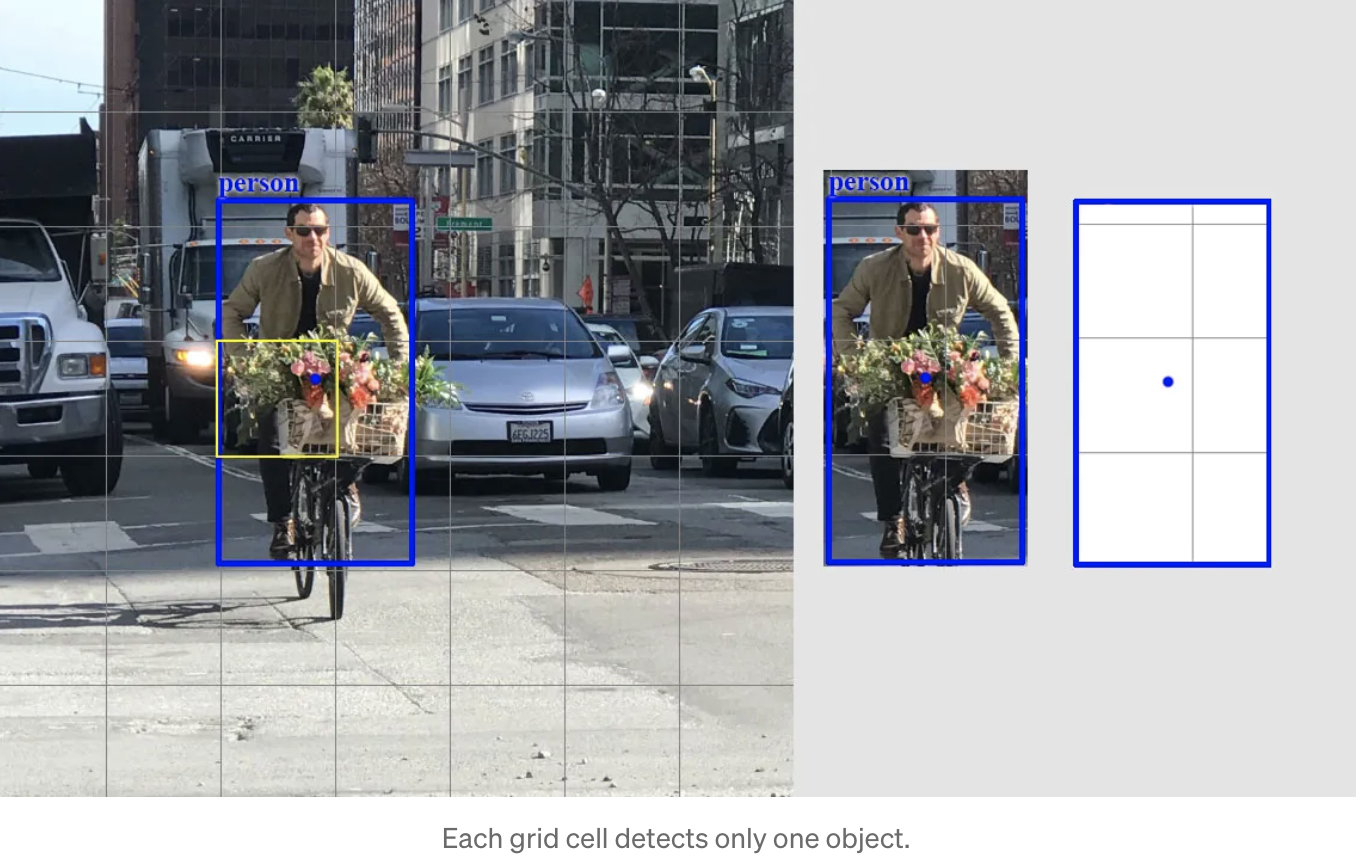

Each grid cell predicts a fixed number of boundary boxes. In this example, the yellow grid cell makes two boundary box predictions (blue boxes) to locate where the person is.


### Bounding Boxes

Bounding boxes are pivotal in object detection, serving as the basic element for localizing objects within an image. A bounding box is defined by four parameters: the $(x$) and $(y$) coordinates of the upper-left corner, and the width $(w$) and height $(h$) of the rectangle. These parameters enable the precise localization and identification of objects in an image, from a simple person to complex scenes with multiple interacting objects

**Challenges with Bounding Boxes:**

* Accuracy: Precisely predicting the size and location of bounding boxes is challenging, especially with objects of varying scales and orientations.

* Overlap: In densely populated scenes, handling overlapping boxes requires careful consideration, often addressed through techniques like Non-Maximum Suppression (NMS).

For each grid cell,

* it predicts B boundary boxes and each box has one box confidence score,
* it detects one object only regardless of the number of boxes B,
* it predicts C conditional class probabilities (one per class for the likeliness of the object class).

To evaluate the images, YOLO uses 7×7 grids (S×S), 2 boundary boxes (B) and 20 classes (C).

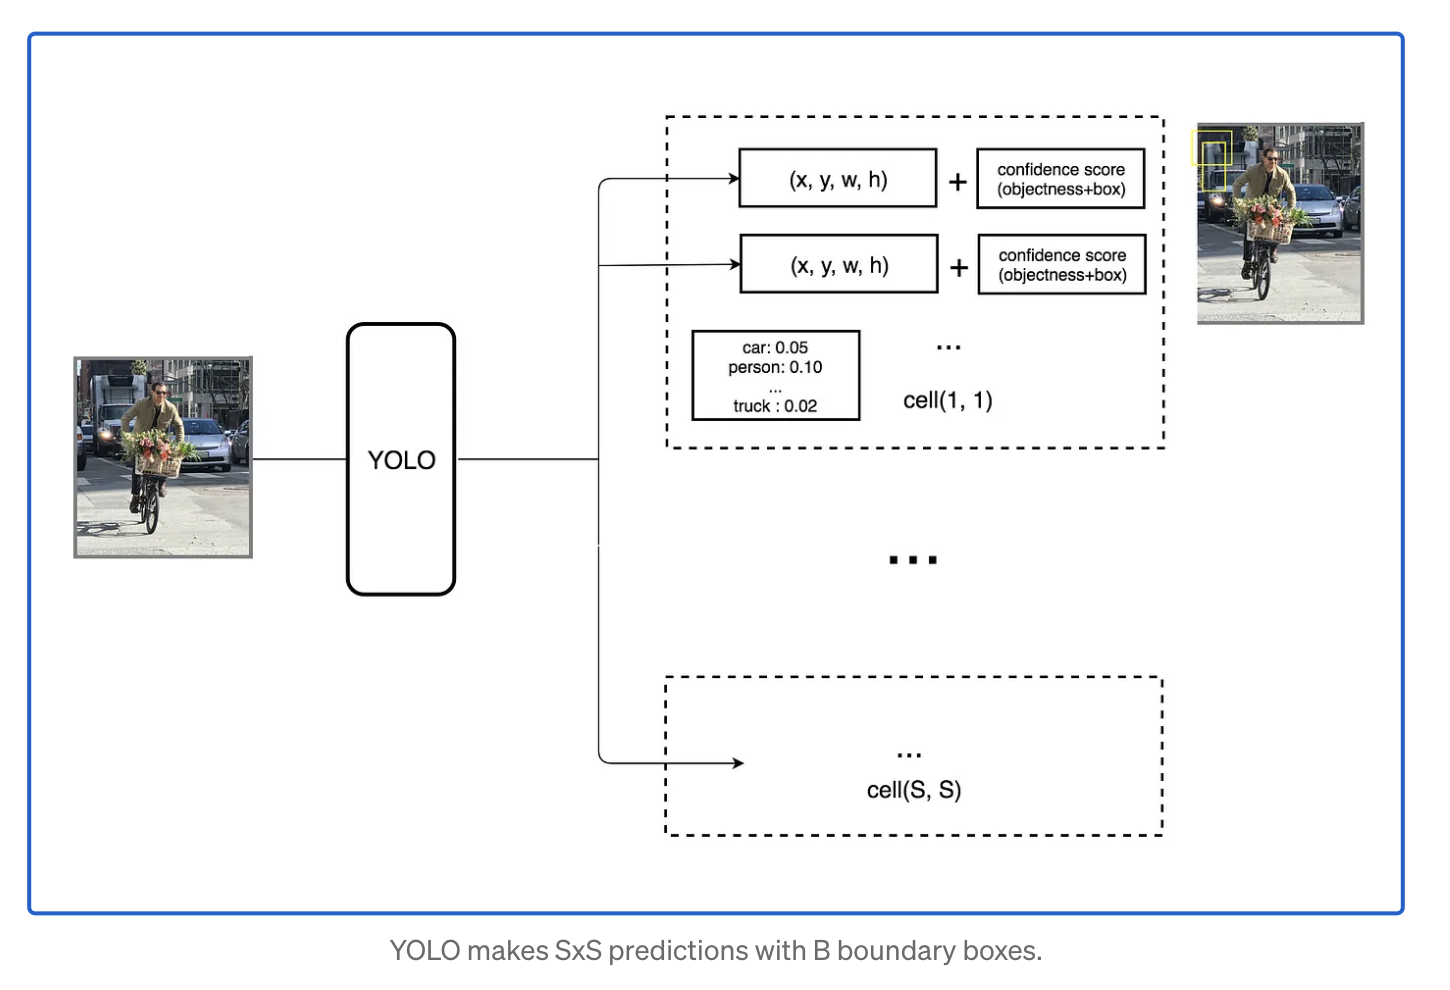

Let’s get into more details.

Each boundary box contains 5 elements: $(x, y, w, h)$ and a `box confidence score`. The confidence score reflects how likely the box contains an object (`objectness`) and how accurate is the boundary box. We normalize the bounding box width $(w)$ and height $(h)$ by the image width and height. $(x)$ and $(y)$ are offsets to the corresponding cell. Hence, $(x)$, $(y)$, $(w)$ and $(h)$ are all between 0 and 1.

Each cell has 20 conditional class probabilities. The conditional class probability is the probability that the detected object belongs to a particular class (one probability per category for each cell).

So, YOLO’s prediction has a shape of $(S, S, B×5 + C) = (7, 7, 2×5 + 20) = (7, 7, 30)$.

## YOLO Loss Function

Implementing the YOLO loss function is a critical step in training the YOLO object detection model. The loss function is designed to optimize several aspects of the predictions, including the size and location of bounding boxes, the confidence score of those boxes, and the class predictions.

The YOLO loss function is composed of several parts: localization loss, confidence loss (objectness), and classification loss. These components are designed to ensure that the model accurately predicts bounding boxes, detects the presence of objects, and classifies those objects correctly.

It is also important to understnd Intersection ove Union concept, which quantizes the prediction of bounding boxes to real object's boxes ratio.



### 1. Localization Loss

Localization loss measures the error in the predicted bounding box location and size compared to the ground truth. YOLO parameterizes bounding boxes using the center coordinates $((x,y)$), width $(w$), and height $(h$). The loss is calculated only for the box responsible for detecting the object.

Mathematically, it is represented as:

$$
L_{\text{loc}} = \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (w_i - \hat{w}_i)^2 + (h_i - \hat{h}_i)^2 \right]
$$

where $( 1_{ij}^{\text{obj}} $) indicates if object appears in cell $( i )$ and bounding box $( j )$ is responsible for that prediction. $( \lambda_{\text{coord}} )$ increases the weight of this loss compared to other components.


This line computes the localization loss by comparing the predicted bounding boxes (`box_predictions`) with the ground truth (`box_targets`). It uses mean squared error (MSE) as the loss function, scaled by `lambda_coord` to adjust its contribution to the total loss.
 &nbsp;

```python
# Localization Loss
box_loss = self.lambda_coord * F.mse_loss(box_predictions, box_targets, reduction="sum")

```


### 2. Confidence Loss

Confidence loss measures the error in the confidence score of the bounding box. The confidence score reflects the model's certainty that a box contains an object and how accurate it thinks the box is.

It consists of two parts: loss for boxes with objects $( 1_{ij}^{\text{obj}} )$ and loss for boxes without objects $( 1_{ij}^{\text{noobj}} )$:

$$
L_{\text{conf}} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2 + \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2
$$

where $( C_i )$ is the confidence score.

```python
# Object Loss
obj_loss = F.mse_loss(exists_box * predictions[..., self.num_classes], exists_box * target[..., self.num_classes], reduction="sum")

# No-object Loss
no_obj_loss = self.lambda_noobj * F.mse_loss((1 - exists_box) * predictions[..., self.num_classes], (1 - exists_box) * target[..., self.num_classes], reduction="sum")
```
 &nbsp;

`obj_loss` calculates the error for boxes that are supposed to contain objects, while `no_obj_loss` does the same for boxes that do not contain objects, scaled by `lambda_noobj`. Most boxes do not contain any objects. This causes a class imbalance problem, i.e. we train the model to detect background more frequently than detecting objects. To remedy this, we weight this loss down by a factor `lambda_noobj` (default: 0.5).

### 3. Classification Loss

Classification loss measures the error in the predicted class probabilities compared to the ground truth. This component is active only for the cell containing the object.

$$
L_{\text{class}} = \sum_{i=0}^{S^2} 1_{i}^{\text{obj}} \sum_{c \in \text{classes}} (p_i(c) - \hat{p}_i(c))^2
$$

where $( p_i(c) )$ is the predicted probability for class $( c )$ in cell $( i )$.
 &nbsp;

```python
# Classification Loss
class_loss = F.mse_loss(exists_box * predictions[..., :self.num_classes], exists_box * target[..., :self.num_classes], reduction="sum")
```
 &nbsp;

This line computes the classification loss by comparing the predicted class probabilities `(predictions[..., :self.num_classes])` with the ground truth `(target[..., :self.num_classes])`, only for the cells that contain an object.


### Loss

The final loss adds localization, confidence and classification losses together.

$$
L_{\text{total}} = \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] + \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left[ \left(w_i - \hat{w_i} \right)^2 + \left(h_i - \hat{h_i} \right)^2 \right] + \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{obj}} \left( C_i - \hat{C}_i \right)^2 + \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{\text{noobj}} \left( C_i - \hat{C}_i \right)^2 + \sum_{i=0}^{S^2} 1_{i}^{\text{obj}} \sum_{c \in \text{classes}} \left( p_i(c) - \hat{p}_i(c) \right)^2
$$

This equation combines the different components of the YOLO loss function: localization loss (first two terms), confidence loss for objects and no-objects (third and fourth terms), and classification loss (fifth term).

Each part is weighted accordingly to reflect its importance in the overall performance of the model.


### Intersection Over Union (IoU)

IoU is a fundamental metric in object detection used to quantify the accuracy of a predicted bounding box against the ground truth. It is defined as the ratio of the area of overlap between the predicted bounding box and the ground truth box to the area of their union.

#### IoU Calculation:

$$
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$



#### Importance of IoU:

**Performance Evaluation:** IoU provides a clear and straightforward measure to evaluate and compare the performance of object detection models.

**Training Optimization:** By integrating IoU into the loss function, models can be trained more effectively to predict accurate bounding boxes.

#### Challenges and Solutions:

**Small Objects:** Detecting small objects can be difficult due to their limited presence in the image. Strategies like using higher resolution input images or focusing on specific layers of the network that retain fine-grained details can help.

**Class Imbalance:** Some classes might be overrepresented in the training data. Techniques such as focal loss or oversampling smaller classes can mitigate this issue.

In summary, the YOLO object detection system, with its innovative approach to bounding box prediction and class probability estimation, coupled with the critical metric of IoU, presents a powerful tool for real-time, accurate object detection across a wide range of applications. Understanding these concepts deeply not only aids in leveraging YOLO's full potential but also in navigating the challenges inherent in object detection tasks.

### Implementation

In [ ]:
class YOLOLoss(nn.Module):
    def __init__(self, grid_size, num_boxes, num_classes, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()

        self.grid_size = grid_size  # grid size
        self.num_boxes = num_boxes  # number of bounding boxes
        self.num_classes = num_classes  # number of classes

        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target):
        # Reshape predictions and target to (batch_size, S, S, C+B*5)
        predictions = predictions.reshape(-1, self.grid_size, self.grid_size, self.num_classes + self.num_boxes * 5)
        target = target.reshape(-1, self.grid_size, self.grid_size, self.num_classes + self.num_boxes * 5)

        # Calculate IoU for the two predicted bounding boxes with target
        iou_b1 = self.compute_iou(predictions[..., self.num_classes+1:self.num_classes+5], target[..., self.num_classes+1:self.num_classes+5])
        iou_b2 = self.compute_iou(predictions[..., self.num_classes+6:self.num_classes+10], target[..., self.num_classes+1:self.num_classes+5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        best_iou, best_box = ious.max(0)

        # 1 for the responsible box, 0 otherwise
        exists_box = target[..., self.num_classes].unsqueeze(3)  # Identity obj_i

        # Localization Loss
        box_predictions = exists_box * (
            (
                best_box * predictions[..., self.num_classes+6:self.num_classes+10]
                + (1 - best_box) * predictions[..., self.num_classes+1:self.num_classes+5]
            )
        )
        box_targets = exists_box * target[..., self.num_classes+1:self.num_classes+5]
        box_loss = self.lambda_coord * F.mse_loss(box_predictions, box_targets, reduction="sum")

        # Confidence Loss
        obj_loss = F.mse_loss(exists_box * predictions[..., self.num_classes], exists_box * target[..., self.num_classes], reduction="sum")
        no_obj_loss = self.lambda_noobj * F.mse_loss((1 - exists_box) * predictions[..., self.num_classes], (1 - exists_box) * target[..., self.num_classes], reduction="sum")

        # Classification Loss
        class_loss = F.mse_loss(exists_box * predictions[..., :self.num_classes], exists_box * target[..., :self.num_classes], reduction="sum")

        total_loss = box_loss + obj_loss + no_obj_loss + class_loss
        return total_loss

    def compute_iou(self, box1, box2):
      """
      Computes the IoU between two sets of boxes.
      box1, box2: (batch_size, grid_size, grid_size, 4) representing (x, y, w, h) for each box.
      """
      # Convert boxes from (x, y, w, h) to (x1, y1, x2, y2)
      box1_x1 = box1[..., 0] - box1[..., 2] / 2
      box1_y1 = box1[..., 1] - box1[..., 3] / 2
      box1_x2 = box1[..., 0] + box1[..., 2] / 2
      box1_y2 = box1[..., 1] + box1[..., 3] / 2

      box2_x1 = box2[..., 0] - box2[..., 2] / 2
      box2_y1 = box2[..., 1] - box2[..., 3] / 2
      box2_x2 = box2[..., 0] + box2[..., 2] / 2
      box2_y2 = box2[..., 1] + box2[..., 3] / 2

      # Intersection area
      inter_area = (torch.min(box1_x2, box2_x2) - torch.max(box1_x1, box2_x1)).clamp(min=0) * \
                  (torch.min(box1_y2, box2_y2) - torch.max(box1_y1, box2_y1)).clamp(min=0)

      # Union Area
      box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
      box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
      union_area = box1_area + box2_area - inter_area

      # IoU
      iou = inter_area / union_area.clamp(min=1e-6)
      return iou



This implementation introduces several hyperparameters, such as ***lambda_coord*** and ***lambda_noobj***, which are used to balance the different components of the loss function. Adjusting these parameters can have a significant impact on the model's performance, particularly in terms of balancing the trade-off between localization accuracy and confidence in predictions.

By breaking down the YOLO loss into its constituent parts and carefully implementing the calculations, this loss function enables effective training of YOLO models on a variety of datasets.

## Model Architecture

We employ a pretrained network for feature extraction, utilizing transfer learning to improve efficiency and accuracy. Specifically, we modify ResNet34, pretrained on ImageNet, to suit our object detection task. The model's final layer is adapted to predict bounding boxes and class probabilities.

The YOLO object detection model consists of two primary components:

**Feature Extractor:** Utilizes a pretrained ResNet-34 model, with its final layer removed, to extract meaningful features from input images. ResNet-34 is chosen for its balance between accuracy and computational efficiency, making it suitable for a wide range of object detection tasks. The feature extractor processes input images to produce a set of feature maps that encode spatial hierarchies of features learned from vast amounts of visual data.

**Detection Layer:** A custom sequence of layers designed to interpret the feature maps and output object detection predictions. This component includes a flattening layer to transform the feature maps into a vector, followed by fully connected layers and nonlinear activations to predict the properties of bounding boxes (location, size) and the probabilities of object classes within each grid cell of the image.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class YOLOObjectDetector(nn.Module):
    """
    YOLO Object Detection model leveraging a pretrained backbone for feature extraction.

    Attributes:
        feature_extractor (nn.Sequential): Feature extraction model.
        detection_layer (nn.Sequential): Custom layer to output detection predictions.
        image_size (int): The size of the input images (square images).
        grid_size (int): The dimension of the output grid (S x S).
        num_boxes (int): Number of bounding boxes (B) to predict per grid cell.
        num_classes (int): Number of object classes (C).
    """
    def __init__(self, backbone, image_size, grid_size, num_boxes, num_classes):
        """
        Initializes the YOLO object detection model with a given backbone.

        Parameters:
            backbone (nn.Module): Pretrained CNN model to use as the feature extraction backbone.
            image_size (int): Size of the input images. Assumes square images.
            grid_size (int): The dimension of the grid size into which the image is divided.
            num_boxes (int): Number of bounding boxes to predict for each grid cell.
            num_classes (int): Number of object classes for classification.
        """
        super(YOLOObjectDetector, self).__init__()
        self.image_size = image_size
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes

        # Modify the backbone by removing the final layer
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])

        # Calculate the size of the flattened features after the feature extractor
        dummy_input = torch.autograd.Variable(torch.rand(1, 3, image_size, image_size))
        features_size = self.feature_extractor(dummy_input).data.view(1, -1).size(1)

        # Define the final layer to output the detection predictions
        self.detection_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(features_size, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, grid_size * grid_size * (num_classes + num_boxes * 5)),
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters:
            x (torch.Tensor): Input tensor of images.

        Returns:
            torch.Tensor: The model's predictions for each image.
        """
        features = self.feature_extractor(x)
        predictions = self.detection_layer(features)
        output_shape = (-1, self.grid_size, self.grid_size, (self.num_classes + self.num_boxes * 5))
        return predictions.reshape(output_shape)

### Understanding the Output Size Calculation

The output size of the YOLO object detection model is calculated as $(grid\_size * grid\_size * (num\_classes + num\_boxes * 5)$) to encapsulate all the necessary information for detecting objects within an image. This formula is a direct consequence of the YOLO model's design, which divides the image into a grid and predicts bounding boxes and class probabilities for each cell in the grid. Let's break down the components of this formula:

1. grid_size * grid_size:

The image is divided into a grid of size grid_size x grid_size. For each cell in this grid, the model will make predictions. This division allows the model to localize objects by determining which grid cell they belong to.

2. num_classes:
For each grid cell, the model predicts the probabilities of each class that the cell may contain. This requires num_classes outputs per cell, allowing the model to classify the detected objects into one of the predefined categories.

3. num_boxes:
Each grid cell predicts num_boxes bounding boxes. These boxes are the model's candidates for enclosing objects detected within the cell. Multiple boxes per cell allow the model to propose different shapes and sizes, improving its ability to accurately bound objects.
4. *5: For each bounding box, the model outputs 5 values:

* x and y coordinates of the box's center relative to the bounds of the grid cell.
* width and height of the box, usually normalized by the image's width and height.
* A confidence score that represents the likelihood of the box containing an object and how accurate the box is expected to be. This score is a combination of objectness (the probability that there is an object) and IoU (Intersection over Union) between the predicted box and the ground truth.

Putting it all together, for each grid cell, the model outputs a vector of length $((num_classes + num_boxes * 5)$). Since there are $(grid\_size * grid\_size$) cells, the total output size becomes $(grid\_size * grid\_size * (num\_classes + num\_boxes * 5)$).

**Why This Output Structure?**

This structure is key to YOLO's single-shot detection capability. By predicting bounding boxes and class probabilities simultaneously for each grid cell, YOLO can detect multiple objects across different classes in a single forward pass through the network. This approach contrasts with two-stage detectors that first propose regions and then classify them, resulting in greater efficiency and speed, which are critical for real-time applications.

## View Data

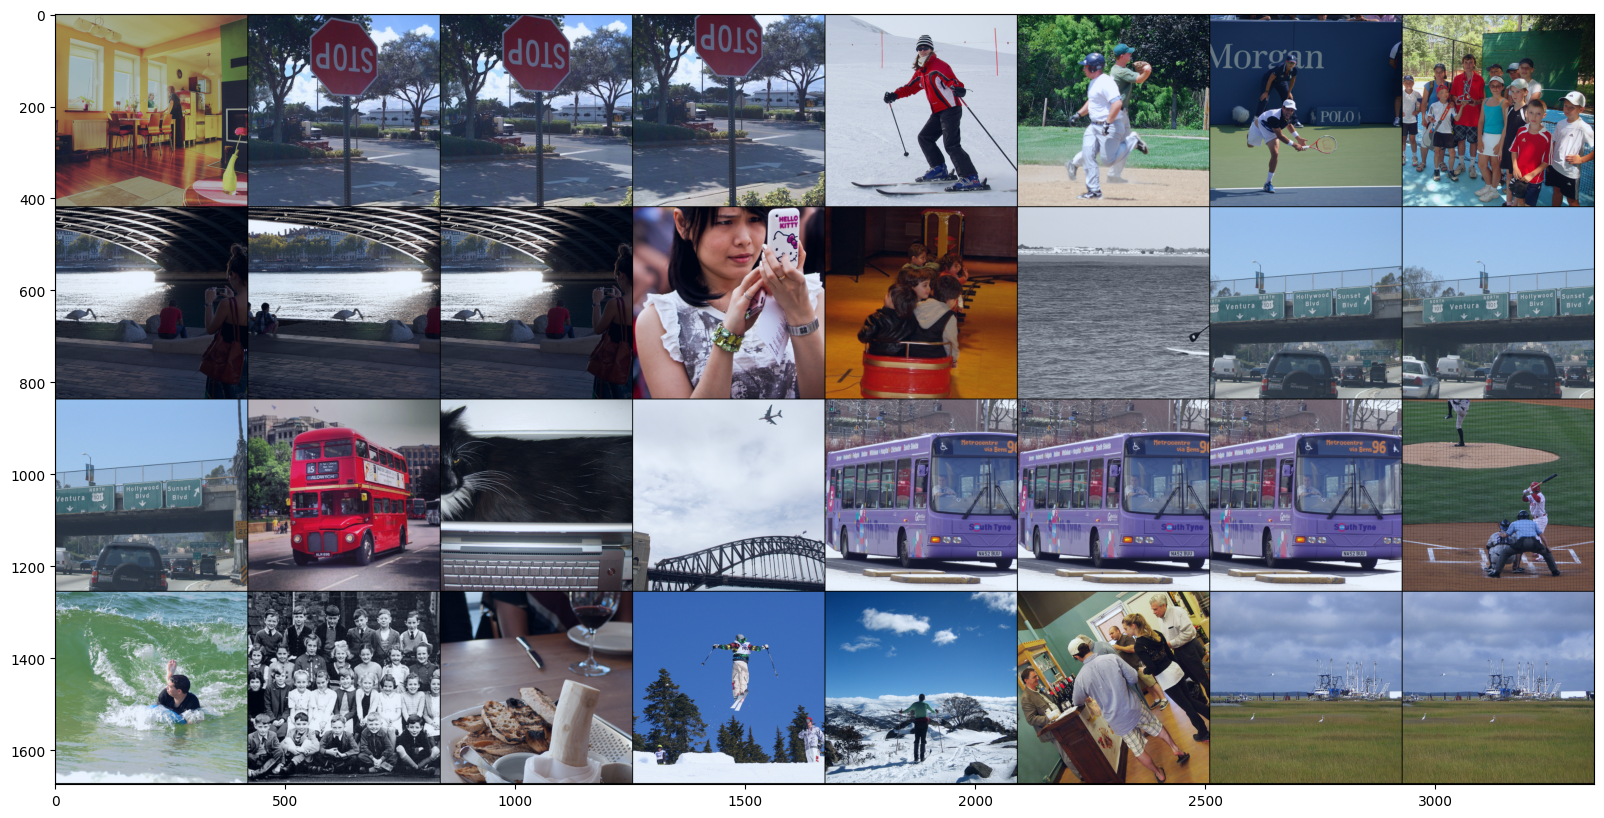

In [ ]:
plt.figure(figsize = (20,10))
images, targets = next(iter(val_loader))
out = torchvision.utils.make_grid(images, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Training

In [ ]:
from torch.optim import Adam

# Parameters
image_size = 416  # Example image size, adjust as needed
grid_size = 7     # Common choice for YOLO
num_boxes = 2     # Typically 2 or 3
num_classes = 20  # Adjust based on your dataset

# Initialize the backbone
backbone = models.resnet34(pretrained=True)

# Create our network
yolo_model = YOLOObjectDetector(backbone=backbone,
                                image_size=image_size,
                                grid_size=grid_size,
                                num_boxes=num_boxes,
                                num_classes=num_classes).to(device)

# Learning rate
learning_rate = 1e-4

# Setup optimizer
optimizer = Adam(yolo_model.parameters(), lr=learning_rate)

# YOLO Loss
loss_function = YOLOLoss(grid_size=grid_size, num_boxes=num_boxes, num_classes=num_classes).to(device)

# Number of epochs
num_epochs = 10

# Evaluation metric is IOU
eval_metric = loss_function.compute_iou

loss_log = []
train_acc_logger = []
val_acc_logger = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.1MB/s]


In [ ]:
def evaluate_model(train_val="train"):
    state = "Evaluating "
    if train_val == "train":
        loader = train_loader
        state += "Train Set"
    elif train_val == "val":
        loader = val_loader
        state += "Validation Set"
    else:
        ValueError("Invalid dataset, train_val should be train/val")

    # Initialise counter
    epoch_acc = 0
    yolo_model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader, leave=False, desc=state)):
            with torch.cuda.amp.autocast():
                # Forward pass of image through network
                fx = yolo_model(data[0].to(device))

                # Log the cumulative sum of the acc
                epoch_acc += eval_metric(fx, data).sum().cpu().item()

    # Log the accuracy from the epoch
    if train_val == "train":
        train_acc_logger.append(epoch_acc / len(loader.dataset))
    elif train_val == "val":
        val_acc_logger.append(epoch_acc / len(loader.dataset))

    return epoch_acc / len(loader.dataset)


In [ ]:
valid_acc = 0
train_acc = 0

yolo_model.train()

pbar = trange(0, num_epochs, leave=False, desc="Epoch")
for epoch in pbar:

    pbar.set_postfix_str('IoU: Train %.2f, Val %.2f' % (train_acc, valid_acc))

    for images, targets in tqdm(train_loader, leave=False, desc="Training"):

        images = images.to(device)

        optimizer.zero_grad()

        predictions = yolo_model(images)

        loss = loss_function(predictions, targets)

        loss_log.append(loss)

        loss.backward()

        optimizer.step()

    # Call the modules evaluate function for train and validation set
    train_acc = evaluate_model(train_test_val="train")
    valid_acc = evaluate_model(train_test_val="val")

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/3697 [00:00<?, ?it/s]